**Agriculture Pests Classification**

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.preprocessing import image_dataset_from_directory
import numpy as np
import os
import imghdr
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, classification_report, roc_auc_score



<ipython-input-1-73085711e250>:7: DeprecationWarning: 'imghdr' is deprecated and slated for removal in Python 3.13
  import imghdr


In [ ]:
dataset_dir = "/content/drive/MyDrive/PESTS_dataset"

In [ ]:
# Remove invalid/corrupted images
def clean_invalid_images(directory):
    removed = []
    for root, _, files in os.walk(directory):
        for file in files:
            filepath = os.path.join(root, file)
            if imghdr.what(filepath) not in ['jpeg', 'png', 'bmp', 'gif']:
                os.remove(filepath)
                removed.append(filepath)
    print(f"Removed {len(removed)} invalid images.")
    return removed

clean_invalid_images(dataset_dir)

Removed 0 invalid images.


[]

In [ ]:
# Parameters
img_size = (128, 128)
batch_size = 32
seed = 123

In [ ]:
# Split into training and validation datasets
train_ds = image_dataset_from_directory(
    dataset_dir,
    validation_split=0.2,
    subset="training",
    seed=seed,
    image_size=img_size,
    batch_size=batch_size,
    label_mode='int'
)

val_ds = image_dataset_from_directory(
    dataset_dir,
    validation_split=0.2,
    subset="validation",
    seed=seed,
    image_size=img_size,
    batch_size=batch_size,
    label_mode='int'
)

class_names = train_ds.class_names
num_classes = len(class_names)

Found 5493 files belonging to 12 classes.
Using 4395 files for training.
Found 5493 files belonging to 12 classes.
Using 1098 files for validation.


In [ ]:
# Normalize the pixel values
def preprocess(image, label):
    image = tf.cast(image, tf.float32) / 255.0
    return image, label

train_ds = train_ds.map(preprocess).cache().prefetch(tf.data.AUTOTUNE)
val_ds = val_ds.map(preprocess).cache().prefetch(tf.data.AUTOTUNE)

In [ ]:
# Load pre-trained base model
base_model = keras.applications.MobileNetV2(
    weights='imagenet', include_top=False, input_shape=(128, 128, 3)
)
base_model.trainable = False

9406464/9406464 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [ ]:
# Build the model
model = keras.Sequential([
    base_model,
    layers.GlobalAveragePooling2D(),
    layers.Dense(128, activation='relu'),
    layers.Dropout(0.3),
    layers.Dense(num_classes, activation='softmax')
])

In [ ]:
# Compile
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

In [ ]:
# Train
epochs = 5
model.fit(train_ds, validation_data=val_ds, epochs=epochs)

Epoch 1/5
138/138 ━━━━━━━━━━━━━━━━━━━━ 34s 174ms/step - accuracy: 0.4052 - loss: 1.8750 - val_accuracy: 0.6794 - val_loss: 0.9782
Epoch 2/5
138/138 ━━━━━━━━━━━━━━━━━━━━ 13s 16ms/step - accuracy: 0.7077 - loss: 0.9104 - val_accuracy: 0.7031 - val_loss: 0.8920
Epoch 3/5
138/138 ━━━━━━━━━━━━━━━━━━━━ 2s 17ms/step - accuracy: 0.7652 - loss: 0.7296 - val_accuracy: 0.6958 - val_loss: 0.8881
Epoch 4/5
138/138 ━━━━━━━━━━━━━━━━━━━━ 2s 13ms/step - accuracy: 0.8100 - loss: 0.5902 - val_accuracy: 0.6931 - val_loss: 0.9101
Epoch 5/5
138/138 ━━━━━━━━━━━━━━━━━━━━ 2s 15ms/step - accuracy: 0.8279 - loss: 0.5334 - val_accuracy: 0.7113 - val_loss: 0.8787


In [ ]:
# Evaluate
loss, accuracy = model.evaluate(val_ds)
print(f"Validation Accuracy: {accuracy:.2f}")

35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.7154 - loss: 0.8411
Validation Accuracy: 0.71


In [ ]:
# Predict
true_labels = []
predicted_labels = []
predicted_probs = []

for images, labels in val_ds:
    preds = model.predict(images)
    predicted_labels.extend(np.argmax(preds, axis=1))
    predicted_probs.extend(preds)
    true_labels.extend(labels.numpy())

true_labels = np.array(true_labels)
predicted_labels = np.array(predicted_labels)
predicted_probs = np.array(predicted_probs)

1/1 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━

In [ ]:
# Classification report
print("\nClassification Report:")
print(classification_report(true_labels, predicted_labels, target_names=class_names))


Classification Report:
              precision    recall  f1-score   support

        ants       0.79      0.77      0.78        95
        bees       0.71      0.85      0.77        88
      beetle       0.36      0.52      0.43        67
catterpillar       0.50      0.58      0.54        90
  earthworms       0.73      0.57      0.64        75
      earwig       0.58      0.43      0.50       104
 grasshopper       0.63      0.62      0.62        91
        moth       0.96      0.84      0.89       101
        slug       0.64      0.58      0.61        81
       snail       0.87      0.99      0.93       103
        wasp       0.80      0.79      0.79        95
      weevil       0.91      0.86      0.89       108

    accuracy                           0.71      1098
   macro avg       0.71      0.70      0.70      1098
weighted avg       0.72      0.71      0.71      1098



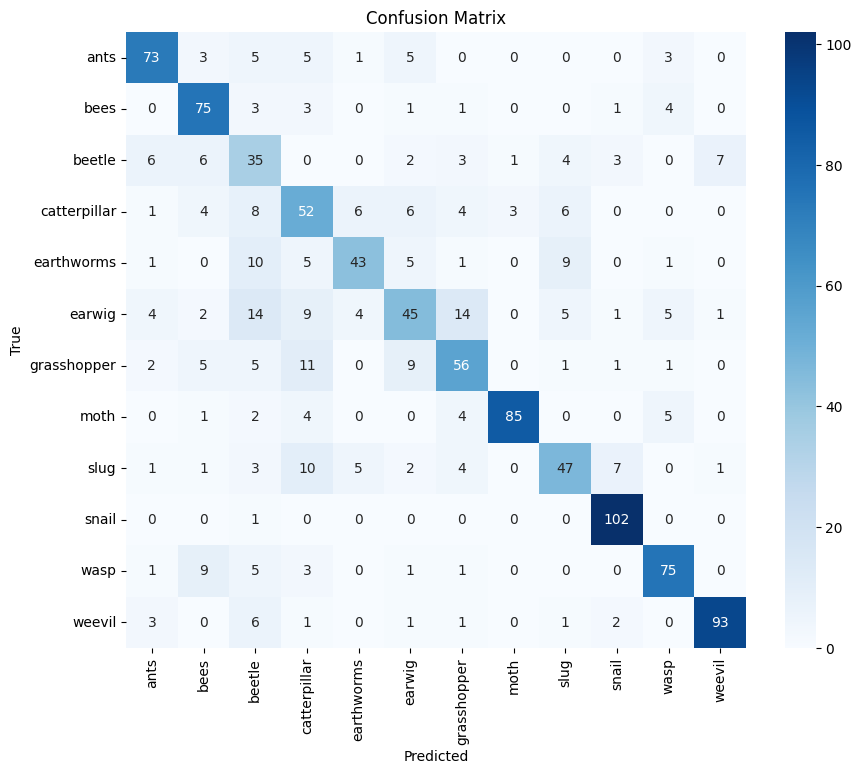

In [ ]:
# Confusion Matrix
import seaborn as sns
conf_matrix = confusion_matrix(true_labels, predicted_labels)
plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, fmt='d', xticklabels=class_names, yticklabels=class_names, cmap='Blues')
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

In [ ]:
# Z-Test
import scipy.stats as stats
z_stat, z_p_value = stats.ttest_1samp(predicted_labels - true_labels, 0)
print(f"Z-Test: Z={z_stat:.2f}, p-value={z_p_value:.4f}")

Z-Test: Z=-2.37, p-value=0.0181


In [ ]:
# T-Test
t_stat, t_p_value = stats.ttest_rel(predicted_labels, true_labels)
print(f"T-Test: T={t_stat:.2f}, p-value={t_p_value:.4f}")

T-Test: T=-2.37, p-value=0.0181


In [ ]:
# ANOVA Test
anova_stat, anova_p_value = stats.f_oneway(predicted_labels, true_labels)
print(f"ANOVA Test: F={anova_stat:.2f}, p-value={anova_p_value:.4f}")

ANOVA Test: F=1.34, p-value=0.2465


In [ ]:
# Type 1 & Type 2 Errors
false_positives = np.sum((predicted_labels != true_labels) & (true_labels == 0))
false_negatives = np.sum((predicted_labels != true_labels) & (true_labels == 1))
total_samples = len(true_labels)

type1_error_rate = false_positives / total_samples
type2_error_rate = false_negatives / total_samples

print(f"Type 1 Error Rate: {type1_error_rate:.2f}")
print(f"Type 2 Error Rate: {type2_error_rate:.2f}")

Type 1 Error Rate: 0.02
Type 2 Error Rate: 0.01


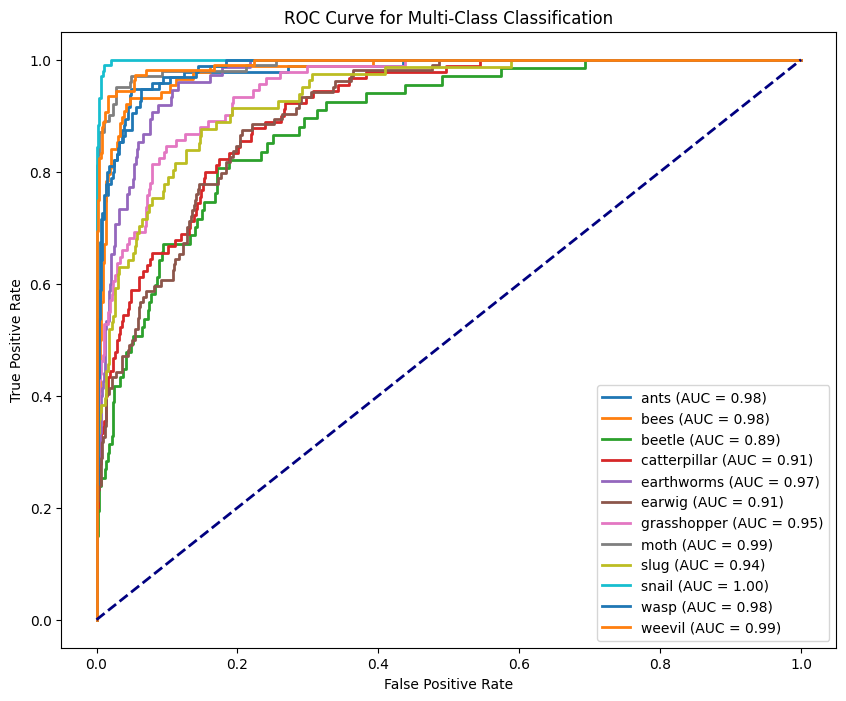

In [ ]:
# ROC Curve (One-vs-Rest for Multi-Class)
# Import label_binarize
from sklearn.preprocessing import label_binarize
from sklearn.metrics import roc_curve, auc

# Binarize the labels for multi-class ROC curve
true_labels_bin = label_binarize(true_labels, classes=np.arange(num_classes))

# Plot ROC curve for each class
plt.figure(figsize=(10, 8))
for i in range(num_classes):
    fpr, tpr, _ = roc_curve(true_labels_bin[:, i], predicted_probs[:, i])
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, lw=2, label=f'{class_names[i]} (AUC = {roc_auc:.2f})')

# Plot ROC curve (Random Classifier)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve for Multi-Class Classification')
plt.legend(loc="lower right")
plt.show()


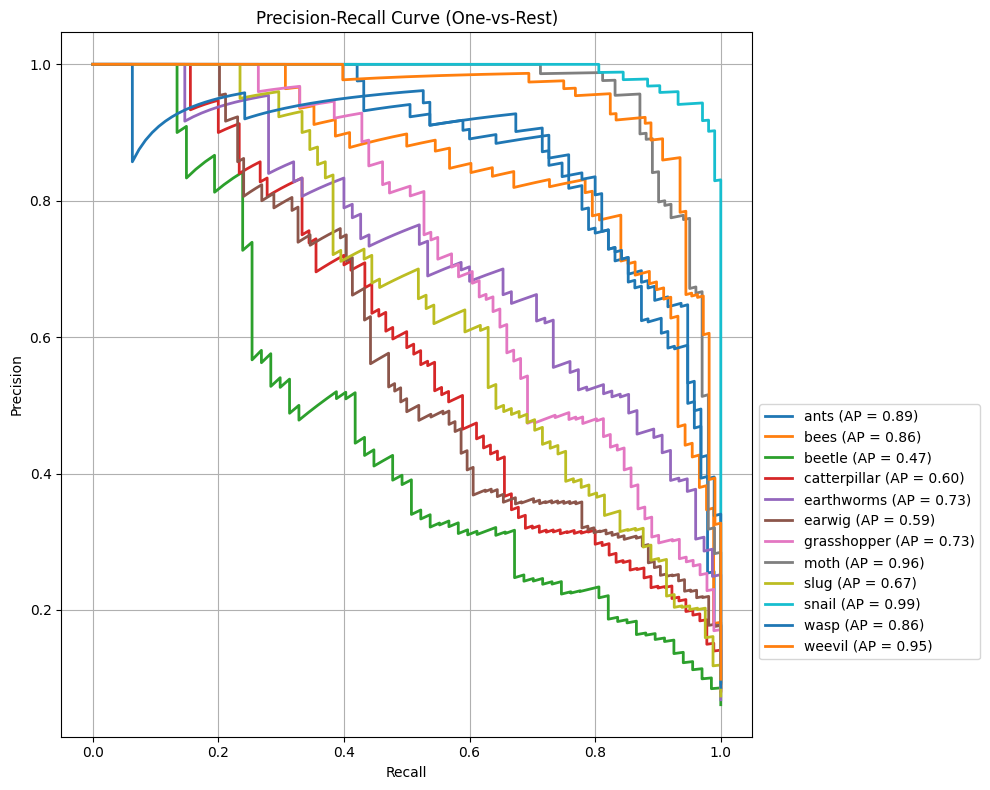

In [ ]:
from sklearn.metrics import precision_recall_curve, average_precision_score

# Precision-Recall Curve
plt.figure(figsize=(10, 8))
for i in range(num_classes):
    precision, recall, _ = precision_recall_curve(true_labels_bin[:, i], predicted_probs[:, i])
    avg_precision = average_precision_score(true_labels_bin[:, i], predicted_probs[:, i])
    plt.plot(recall, precision, lw=2, label=f'{class_names[i]} (AP = {avg_precision:.2f})')

plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve (One-vs-Rest)')
plt.legend(loc="lower left", bbox_to_anchor=(1.0, 0.1))
plt.grid(True)
plt.tight_layout()
plt.show()

In [ ]:
# Mean Average Precision
mean_ap = average_precision_score(true_labels_bin, predicted_probs, average="macro")
print(f"Mean Average Precision (mAP): {mean_ap:.2f}")


Mean Average Precision (mAP): 0.77
